----
# Example using the extra features for QAOA circuits
----

The Quantum Approximate Optimization Algorithm (QAOA) is a variational algorithm to solve combinatorial problems.
Here we provide the syntax to quickly define and simulate QAOA circuits.

As a concrete example, we consider the MaxCut problem on a linear graph of 6 vertices. It is trivially solved analytically, but the numerical procedure extends to more complicated instances.

**NOTE:**
Currently, the Python implementation only allows for single-core execution and does not take advantages of the MPI protocol.

### Import Intel QS library

We start by importing the Python library with the class and methods defined in the C++ implementation.

In [1]:
# Import the Python library with the C++ class and methods of Intel Quantum Simulator.
# If the library is not contained in the same folder of this notebook, its path has to be added.
import sys
sys.path.insert(0, '../build/lib')
import intelqs_py as simulator

# Import NumPy library with Intel specialization.
import numpy as np
from numpy import random_intel

# Import graphical library for plots.
import matplotlib.pyplot as plt

### Initialize the Max-Cut problem instance via its adjacency matrix

Specific instance:
0 -- 1 -- 2 -- 3 -- 4 -- 5

We describe the instance by its adjacency matrix $A$, represented as a bidimensional NumPy array.

Each of the $2^6$ bipartitions of the 6 vertices is associated with a cut value (the number of edges connecting vertices of different color).

In [2]:
# Number of vertices.
num_vertices = 6;
# Adjacency matrix.
A = np.zeros((num_vertices,num_vertices),dtype=np.int32);
# Since A is sparse, fill it element by element.
A[0,1] = 1;
A[1,0] = 1;
A[1,2] = 1;
A[2,1] = 1;
A[2,3] = 1;
A[3,2] = 1;
A[3,4] = 1;
A[4,3] = 1;
A[4,5] = 1;
A[5,4] = 1;
print("The adjacency matrix of the graph is:\n")
print(A)
#print(list(A.flatten()))

# Allocate memory for the diagonal of the objective function.
diag_cuts = simulator.QubitRegister(num_vertices, "base", 0, 0);
max_cut = simulator.InitializeVectorAsMaxCutCostFunction( diag_cuts, list(A.flatten()) );

print("\nThe max value of the cut is : {0:2d}".format(max_cut))

The adjacency matrix of the graph is:

[[0 1 0 0 0 0]
 [1 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 0]]

The max value of the cut is :  5


### Implement a p=2 QAOA circuit
----

- initialize the state in $|000000\rangle$
- prepare the state in $|++++++\rangle$
- iterate throught the QAOA steps (here p=2)
- each step is composed by the global operation defined by the cost function C and the transverse field mixing

In [3]:
# Number of qubits.
num_qubits = num_vertices;
# Allocate memory for the quantum register's state and initialize it to |000000>.
psi = simulator.QubitRegister(num_qubits, "base", 0, 0);

# Prepare state |++++++>
for qubit in range(num_qubits):
    psi.ApplyHadamard(qubit);

# QAOA circuit:
qaoa_depth = 2;
# Random choice of QAOA parameters.
np.random.seed(7777);
gamma = np.random.random_sample((qaoa_depth,))*3.14159;
beta  = np.random.random_sample((qaoa_depth,))*3.14159;

for p in range(qaoa_depth):
    # exp(-i gamma C)
    simulator.ImplementQaoaLayerBasedOnCostFunction(psi, diag_cuts, gamma[p]);
    # exp(-i beta  B)
    for qubit in range(num_qubits):
        psi.ApplyRotationX(qubit,beta[p]);

# At this point |psi> corresponds to the state at the end of the QAOA circuit.

### Collect the results and visualize them in a histogram

The probabilities of the cut values are:
cut= 0 :  0.0397
cut= 1 :  0.1778
cut= 2 :  0.3483
cut= 3 :  0.2986
cut= 4 :  0.1120
cut= 5 :  0.0236


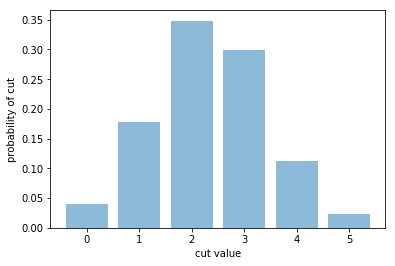

In [4]:
# The form of the histogram has been discussed privately.
histo = simulator.GetHistogramFromCostFunction(psi, diag_cuts, max_cut);
print("The probabilities of the cut values are:")
for c in range(max_cut+1):
    print("cut={0:2d} :  {1:1.4f}".format(c,histo[c]))

# Plot histogram.
x = np.arange(max_cut+1)
fig = plt.bar(x, histo, align='center', alpha=0.5)
#plt.xticks(x)
plt.xlabel('cut value')
plt.ylabel('probability of cut')
#plt.title('Summary of results')
plt.show()

### Simple test

This instance represents a disconnected graph with only two edges, namely:
0 -- 1    2    3   4 -- 5

We describe the instance by its adjacency matrix $A$, represented as a bidimensional NumPy array.

Each of the $2^6$ bipartitions of the 6 vertices is associated with a cut value (the number of edges connecting vertices of different color). For Half of the bipartitions the 0--1 edge can be cut and for half of the bipartitions, independently of the previous consideration, the 5--6 edge can be cut. The histogram has three bins (cut values = {0,1,2}) and ratio 1:2:1.

[0.2499999999999999, 0.4999999999999999, 0.2499999999999999]


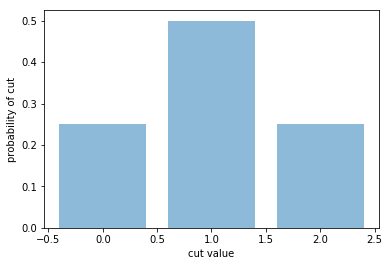

In [5]:
# Number of vertices.
num_vertices = 6;
# Adjacency matrix.
A = np.zeros((num_vertices,num_vertices),dtype=np.int32);
# Since A is sparse, fill it element by element.
A[0,1] = 1;
A[1,0] = 1;
A[num_vertices-2,num_vertices-1] = 1;
A[num_vertices-1,num_vertices-2] = 1;

# Allocate memory for the diagonal of the objective function.
diag_cuts = simulator.QubitRegister(num_vertices, "base", 0, 0);
max_cut = simulator.InitializeVectorAsMaxCutCostFunction( diag_cuts, list(A.flatten()) );

# Number of qubits.
num_qubits = num_vertices;
# Allocate memory for the quantum register's state and initialize it to |000000>.
psi = simulator.QubitRegister(num_qubits, "base", 0, 0);

# Prepare state |++++++>
for qubit in range(num_qubits):
    psi.ApplyHadamard(qubit);

# The form of the histogram has been discussed privately.
histo = simulator.GetHistogramFromCostFunction(psi, diag_cuts, max_cut);
print(histo)

# Plot histogram.
x = np.arange(max_cut+1)
fig = plt.bar(x, histo, align='center', alpha=0.5)
#plt.xticks(x)
plt.xlabel('cut value')
plt.ylabel('probability of cut')
#plt.title('Summary of results')
plt.show()

----
## END
----